Section 1: ORF8 Protein Sequences Retrieved From NCBI Protein Search

In [2]:
# store proteins in dictionary
organisms = {
    'Pangolin':
    'MKFLVFLGIL'
    'TTVTAFHQEC'
    'SLQSCAQHQP'
    'YVVDDPCPIH'
    'FYSRWFIRVG'
    'ARKSAPLIDI'
    'GNYTVSCSPF'
    'TINCQEPKLG'
    'SLVVRCSFYE'
    'DFLEYHDVRV'
    'VLDFI', 
    'Bat':
    'MNIFAVLILV'
    'FIAGCMIDLC'
    'KYLFFALCWL'
    'FIDWPLEHVF'
    'NVLDANFAFS'
    'IFVLISFVLL'
    'PVFWPQAAET'
    'LLNFLDLIAG'
    'LLYSSTFYRQ'
    'LF',
    'Cat':
    'MKFLVFLGII'
    'TTVAAFHQEC'
    'SLQSCTQHQP'
    'YVVDDPCPIH'
    'FYSKWYIRVG'
    'ARKSAPLIEL'
    'CVDEAGSKSP'
    'IQYIDIGNYT'
    'VSCLPFTINC'
    'QEPKLGSLVV'
    'RCSFYEDFLE'
    'YHDVRVVLDF'
    'I',
    'Human':
    'MKFLVFLGII'
    'TTVAAFHQEC'
    'SLQSCTQHQP'
    'YVVDDPCPIH'
    'FYSKWYIRVG'
    'ARKSAPLIEL'
    'CLDEAGXKSP'
    'IQYIDIGNYT'
    'IQYIDIGNYT'
    'QEPKLGSLVV'
    'RCSFYEDFLE'
    'YHDVRVVLDF'
    'I',
    'Horseshoe Bat':
    'MKLLIVLTCI'
    'SLASCLRTVV'
    'QQCSSDKPHV'
    'LQNPCPSSYA'
    'PEWNIRYNTL'
    'GNTYSTAWLC'
    'AFGKVLPFHK'
    'WHTMVKSCSP'
    'NVTIDCVDPA'
    'GGALICRCWY'
    'VHDGHQTASF'
    'RDILVVLNKR'
    'TIHNV'
}

Section 2: Compute Distance Matrix Between Organisms

In [3]:
from numpy import fill_diagonal, where
from pandas import DataFrame
from itertools import combinations

# initialize distance matrix and fill diaganols
distanceMatrix = DataFrame(index=organisms.keys(), columns=organisms.keys())
fill_diagonal(distanceMatrix.values, 0)

# function to get difference between two sequences
def getDif(sequence1, sequence2):
  startDif = 0
  if len(sequence1) > len(sequence2):
    startDif = len(sequence1) - len(sequence2)
  elif len(sequence2) > len(sequence1):
    startDif = len(sequence2) - len(sequence1)
  else:
    startDif = 0
  for s1, s2 in zip(sequence1, sequence2):
    if s1 != s2:
      startDif += 1
  return startDif

distanceDict = {}
for key in combinations(organisms,2):
  # print(key)
  diff = getDif(organisms[key[0]], organisms[key[1]])
  distanceDict.update({key: diff})
# print(distanceDict)

# update DataFrame
beg = 0
end = len(organisms.keys())-1
count = len(organisms.keys()) - 2
for i, j in zip(range(len(organisms.keys()) - 1), range(1, len(organisms.keys()))):
  # print(list(distanceDict.values())[beg:end])
  distanceMatrix.iloc[i, j:] = list(distanceDict.values())[beg:end]
  beg = end
  end += count
  count -= 1
  distanceMatrix.iloc[j:,i] = distanceMatrix.iloc[i, j:] 
# distanceMatrix.head()
dfDict = distanceMatrix.to_dict()

# blankDict = {}
# for mainKey in dfDict.keys():
#   mainDict = dfDict.get(mainKey)
#   blankList = ()
#   for ele in mainDict.keys():
#     blankList = blankList + (mainDict.get(ele),)
#   blankDict[mainKey] = blankList

def getDistanceMatrix():
  return distanceMatrix
print(distanceMatrix)

              Pangolin  Bat  Cat Human Horseshoe Bat
Pangolin             0   97   66    65           115
Bat                 97    0  116   116           119
Cat                 66  116    0    12           117
Human               65  116   12     0           115
Horseshoe Bat      115  119  117   115             0


Section 3: Use UPGMA Algorithm to Construct Phylogenetic Tree


In [5]:
from pandas import DataFrame, IndexSlice
from seaborn import dark_palette
from scipy.cluster.hierarchy import average

#initialize variables
upgma = distanceMatrix.copy()
orgs = upgma.index
cols = {}
tree = {}
colors = upgma.copy()
while upgma.shape != (1,1):
  # get most related organism for each organism in matrix
  related = {}
  smallestDist = float('inf')
  for org in upgma.index:
    closestVals = upgma[org]
    m1, m2 = float('inf'), float('inf')
    for x in closestVals:
          if x <= m1:
              m1, m2 = x, m1
          elif x < m2:
              m2 = x
          if m2 < smallestDist:
            smallestDist = m2
    related.update({org: m2})
  # print(related)
  # print(smallestDist)

  #update which values will cluster first based on color
  colors = upgma.copy().style.background_gradient(cmap=dark_palette('blue', as_cmap=True))

  #get min index 
  minIndex = upgma.iloc[where(upgma == smallestDist)].index
  # set as coord
  minCoord = str(tuple(minIndex))

  #update tree
  tree.update({minCoord: smallestDist / 2})

  # mark which cells to merge 
  colors.applymap(lambda x: 'background-color: red', subset=IndexSlice[minIndex, :])
  colors.applymap(lambda x: 'background-color: red', subset=IndexSlice[:, minIndex])
  colors.applymap(lambda x: 'background-color: yellow', subset=IndexSlice[minIndex, minIndex])

  # update cols
  cols.update({minCoord: colors})

  # cluster cells based on highlights, 
  combined = upgma.loc[minIndex,:].sum() / 2
  combined.drop(minIndex, inplace=True)
  # print(combined)

  # update UPGMA with new values
  upgma.rename(columns={minIndex[0]: minCoord}, index={minIndex[0]: minCoord}, inplace=True)
  upgma.drop(minIndex[1], axis=0, inplace=True)
  upgma.drop(minIndex[1], axis=1, inplace=True)
  upgma.loc[upgma[minCoord] > 0, minCoord] = combined
  upgma.loc[minCoord, upgma[minCoord] > 0] = combined

def getTree():
  return tree
def getUpgma():
  return upgma
print(upgma.head())

                                                   ('(\'(\\\'Pangolin\\\', "(\\\'Cat\\\', \\\'Human\\\')")\', \'Bat\')', 'Horseshoe Bat')
('(\'(\\\'Pangolin\\\', "(\\\'Cat\\\', \\\'Huma...                                                  0                                    


Section 4: Plotting Function to Show Phylogenetic Tree

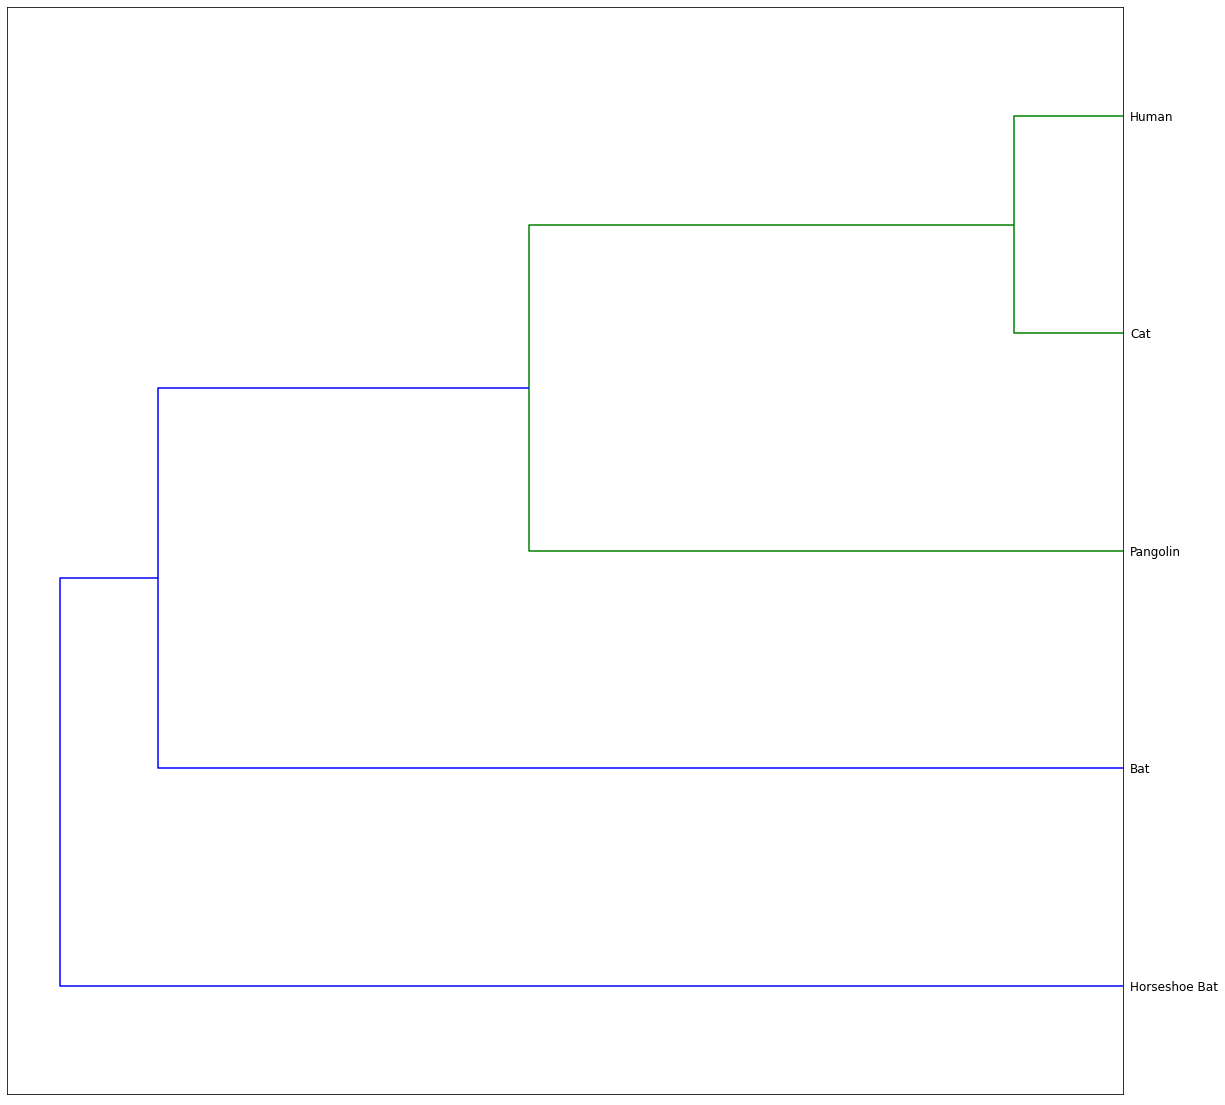

In [10]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import figure
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import squareform
mat = getDistanceMatrix()
t = getTree()
smallUpgma = average(squareform(mat.values))
def plotTree(upgma):
  smallUpgma[:,2] = list(t.values())
  plot, axis= subplots(figsize=(20,20))
  # plot = subplots(figsize(20,20))
  dendrogram(smallUpgma, ax=axis, orientation='left', labels = mat.index)
  axis.set_xticks(range(0))
  plot.show()
u = getUpgma()
plotTree(u)